## Import Libraries and Data

In [2]:
import pandas as pd
import numpy as np

import os
import tarfile
from datetime import datetime

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
pd.options.display.max_colwidth = 150 ###
file = "/Users/adrianacuppuleri/Desktop/GITHUB ADRIANA/un_general_debate/data/un-general-debates.csv"
df = pd.read_csv(file)
df.sample(2, random_state=53)

,session,year,country,text
3871,42,1987,HND,"﻿On behalf of the Government of Honduras I extend to you, Sir, sincere congratulations on your election as President of the forty-second session o..."
4697,35,1980,THA,﻿My delegation takes pleasure in extending to Mr. Riidiger von Wechmar its sincere congratulations on his unanimous election to the presidency of ...


## EDA

Summary Statistics

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  7507 non-null   int64 
 1   year     7507 non-null   int64 
 2   country  7507 non-null   object
 3   text     7507 non-null   object
dtypes: int64(2), object(2)
memory usage: 234.7+ KB
None


In [30]:
df['length'] = df['text'].str.len()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [12]:
df['country'].describe(include='0')

count     7507
unique     199
top        IRN
freq        46
Name: country, dtype: object

Check for Missing Data

Plotting Value Distribuition

<Axes: >

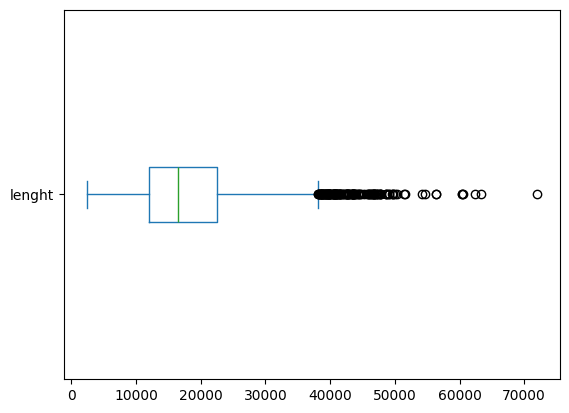

In [14]:
df['length'].plot(kind='box', vert=False)

<Axes: ylabel='Frequency'>

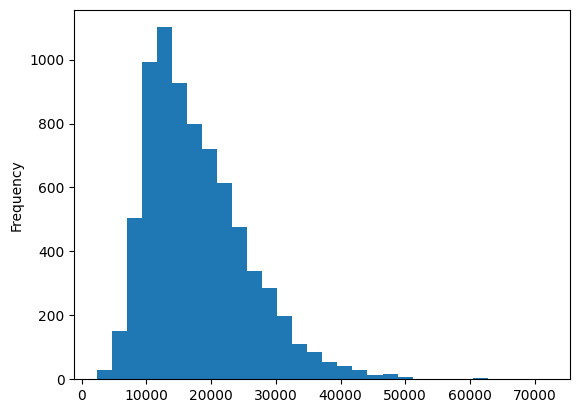

In [15]:
df['length'].plot(kind='hist', bins=30)

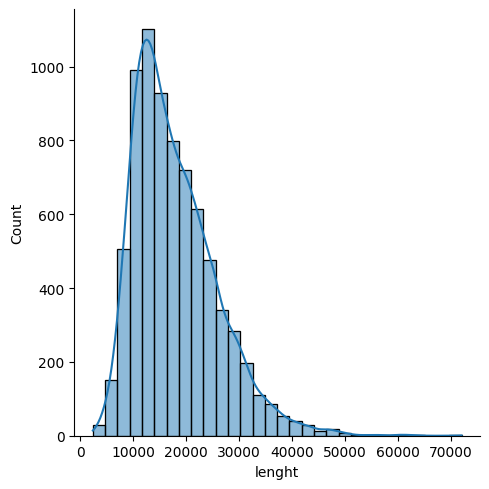

In [23]:
sns.displot(df['length'], bins=30, kde=True)

Comparing Value Distribution

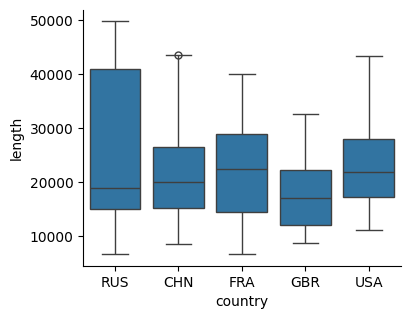

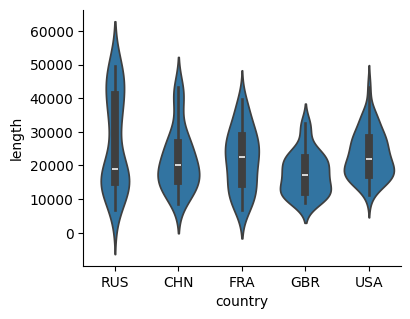

In [32]:
# distribution of speech elnght across UN P5
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="length", kind='box')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###
g = sns.catplot(data=df[where], x="country", y="length", kind='violin')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###

visualizing development over time

<Axes: title={'center': 'Number of Speech per Year'}, xlabel='year'>

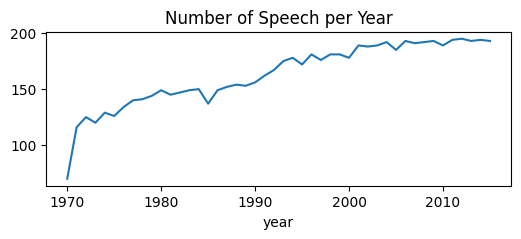

In [35]:
df.groupby('year').size().plot(title="Number of Speech per Year", figsize=(6,2))

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='year'>

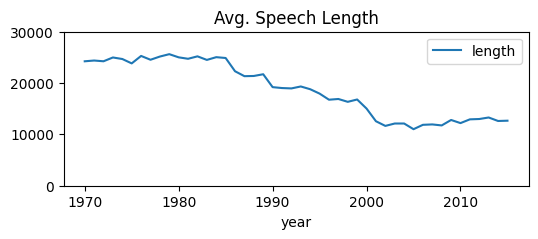

In [36]:
df.groupby('year').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2))

## Text Preprocessing Pipeline

Tokenization with Regular Expressions

In [38]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

Stopwords

In [41]:
import nltk
stopwords = set(nltk.corpus.stopwords.words('english'))


In [42]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [46]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords
#alternative to stopwords: max_df scikit_learn and filter based on POS

In [47]:
#create the pipeline with the following functions
pipeline = [str.lower, tokenize, remove_stop]

#define the function
def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [49]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [51]:
df['num_tokens'] = df['tokens'].map(len)

In [52]:
df.tokens.head()

0    [indeed, pleasure, members, delegation, extend, ambassador, garba, sincere, congratulations, election, presidency, forty-fourth, session, general,...
1    [may, begin, congratulating, sir, election, presidency, general, assembly, forty-fourth, session, wide, experience, united, nations, makes, especi...
2    [mr, president, particular, pleasure, behalf, delegation, niger, congratulate, moat, warmly, brilliant, election, presidency, general, assembly, f...
3    [debate, fortieth, session, general, assembly, four, years, ago, president, sanguinetti, announced, world, community, rostrum, uruguay, resumed, t...
4    [like, outset, express, delegation, satisfaction, pleasure, election, sir, presidency, general, assembly, forty-fourth, session, unanimity, decisi...
Name: tokens, dtype: object

## Word Frequency Analysis

Counting Words with a Counter (BOW)

In [53]:
from collections import Counter

In [56]:
counter = Counter()

df['tokens'].map(counter.update)

0       None
1       None
2       None
3       None
4       None
        ... 
7502    None
7503    None
7504    None
7505    None
7506    None
Name: tokens, Length: 7507, dtype: object

In [57]:
print(counter.most_common(5))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]


In [60]:
#transform the counter into a Pandas DataFrame
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [61]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [62]:
# top words with 10+ characters
count_words(df, column='text', 
            preprocess=lambda text: re.findall(r"\w{10,}", text)).head(5)

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

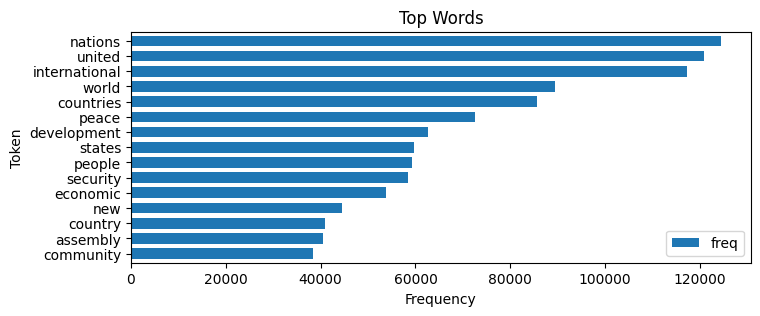

In [65]:
#frequency diagrams
ax = freq_df.head(15).plot(kind='barh', width=0.7, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

Word Clouds

In [66]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [74]:
text = df.query("year==2014 and country=='RUS'")['text'].values[0]
text2 = df.query("year==2015 and country=='RUS'")['text'].values[0]

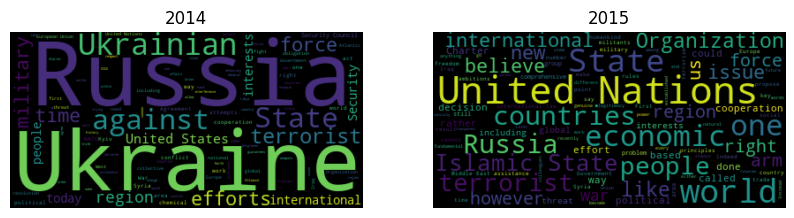

In [78]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Create WordCloud for the first subplot
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
axes[0].imshow(wc, interpolation='bilinear')
axes[0].set_title('2014')  # Set a title if desired
axes[0].axis("off")

# Create WordCloud for the second subplot
wc2 = WordCloud(max_words=100, stopwords=stopwords)
wc2.generate(text2)
axes[1].imshow(wc2, interpolation='bilinear')
axes[1].set_title('2015')  # Set a title if desired
axes[1].axis("off")

plt.show()

In [79]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

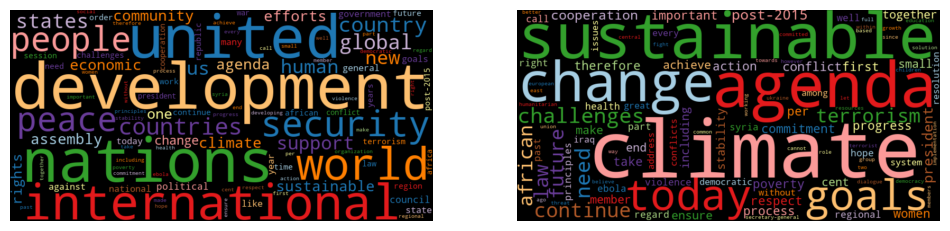

In [81]:
freq_2014_df = count_words(df[df['year']==2014])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_2014_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_2014_df['freq'], max_words=100, stopwords=freq_df.head(50).index)
#plt.tight_layout()###

TF-ITF

In [82]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [83]:
idf_df = compute_idf(df)

/var/folders/mm/gw92vpys6rggjz_4z42s244w0000gn/T/ipykernel_33620/2472289252.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


In [84]:
# high IDF means rare (interesting) term
idf_df.sample(5)

,df,idf
token,,
sectoral,120,4.236099
thinkable,3,7.924979
differentials,5,7.414153
feudalistic,4,7.637297
cooperation,4777,0.552023


In [85]:
#FD*IDF
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [86]:
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']

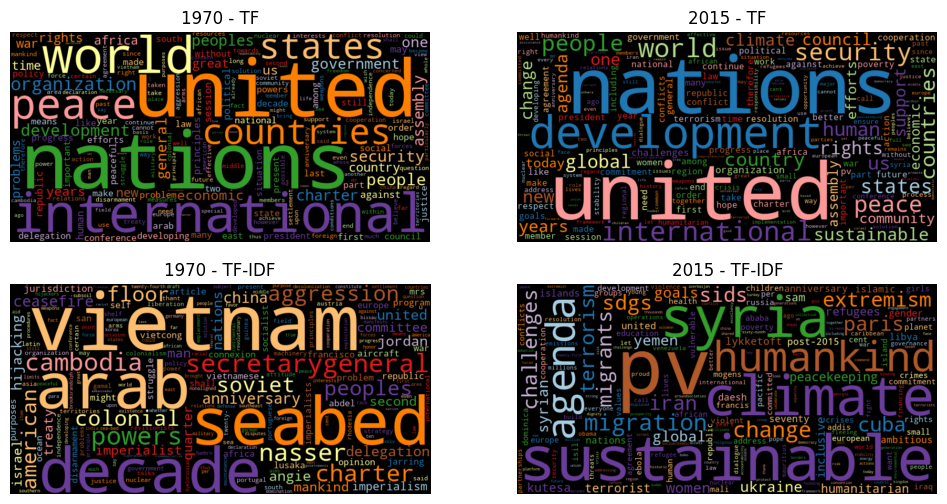

In [87]:
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
plt.subplot(2,2,1)###
wordcloud(freq_1970['freq'], title='1970 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])
plt.subplot(2,2,2)###
wordcloud(freq_2015['freq'], title='2015 - TF', 
          stopwords=['seventieth'])
plt.subplot(2,2,3)###
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
plt.subplot(2,2,4)###
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', 
          stopwords=['seventieth'])

#why not CountVectorizer and TfidVectorizer?
#1) they produce vectors with weighted freq for each single doc and not arbitrary subsets
#2) results are metrics (good for ML) and not DF (good for slicing, aggregation and visualization)

Keyword-in-Context

In [93]:
import textacy
from textacy.extract.kwic import keyword_in_context
import random

In [98]:
def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args, 
                           **{kw: arg for kw, arg in kwargs.items() 
                            if kw != 'print_only'})

In [99]:
def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [100]:
random.seed(22) ###
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

5 random samples out of 73 contexts for 'sdgs':
ill vivid in our memories. The new   SDGs   framework must ensure that account
the Sustainable Development Goals (  SDGs  ). In other words, it is addressing
nd, we are expected to achieve the   SDGs   and to demonstrate dramatic develo
r Sustainable Development with its   SDGs   (resolution 70/1) requires us to d
 of Sustainable Development Goals (  SDGs  ). Given the ambition reflected in 


Bigrams

In [102]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [103]:
#create bigrams on all tokens but keep those that do not contain stopwords
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [104]:
df['bigrams'] = df['text'].apply(prepare, pipeline=[str.lower, tokenize]) \
                          .apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


In [107]:
#calculate fd*ifd including bigrams
idf_df = compute_idf(df) ### re-initialize to be safe
# concatenate existing IDF data frame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

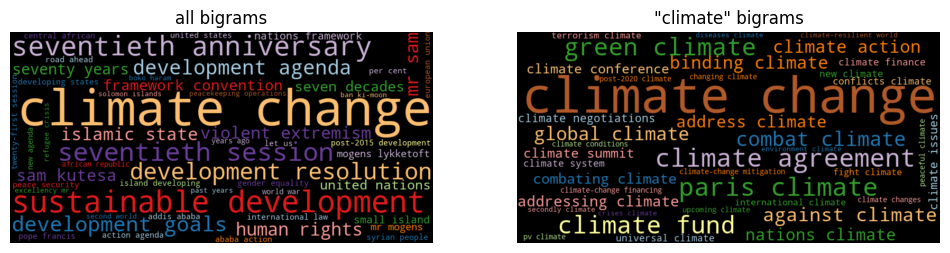

In [106]:
plt.figure(figsize=(12,6)) ###
plt.subplot(1,2,1) ###
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

plt.subplot(1,2,2) ###
# plt.tight_layout() ###
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

## Frequency across Time Intervals and Categories

Frequency Timeline

In [108]:
#calculate frequency of given keywords per document
def count_keywords(tokens, keywords): 
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [113]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom', 'war']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2, 0]


In [114]:
def count_keywords_by(df, by, keywords, column='tokens'):
    
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps in the index
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    
    return freq_df.groupby(by=by).sum().sort_values(by)

In [115]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

<Axes: xlabel='year'>

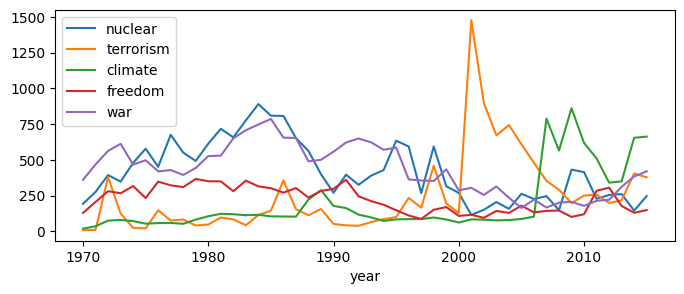

In [116]:
pd.options.display.max_rows = 4
pd.options.display.max_rows = 60
freq_df.plot(kind='line', figsize=(8, 3))

In [120]:
#filter per year and one country
def count_keywords_by(df, by, keywords, column='tokens', country_filter=None):
    if country_filter is not None:
        df = df[df['country'] == country_filter]
    
    df = df.reset_index(drop=True)
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]
    
    return freq_df.groupby(by=by).sum().sort_values(by)

# Example usage for 'year' and 'RUS'
keywords_result_rus = count_keywords_by(df, by='year', keywords=keywords, country_filter='RUS')

<Axes: title={'center': 'Timeline Word Frequency - Russia'}, xlabel='year'>

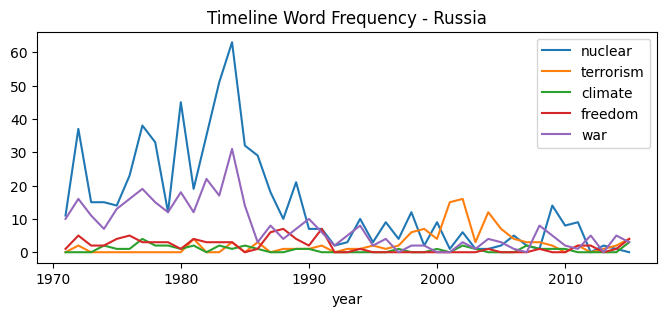

In [123]:
pd.options.display.max_rows = 4
pd.options.display.max_rows = 60
keywords_result_rus.plot(kind='line', figsize=(8, 3), title='Timeline Word Frequency - Russia')

In [117]:
random.seed(23) ###
# analyzing mentions of 'climate' before 1980: mostly in a figurative sense
kwic(df.query('year < 1980')['text'], 'climate', window=35, print_samples=5)

5 random samples out of 581 contexts for 'climate':
ncerned to foster an international   climate   that is conducive to the relaxatio
 to bring about a better political   climate   in the country or its responsibili
cold war. Changes in the political   climate   in Berlin and improvements in the 
e, the opposition is maintaining a   climate   of constant agitation while the Ro
we must try to create a favourable   climate   for co-operation among States, and


Frequency Heatmap

In [127]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping', 
            'humanitarian', 'climate', 'change', 'sovereignty', 'sustainable']

In [128]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

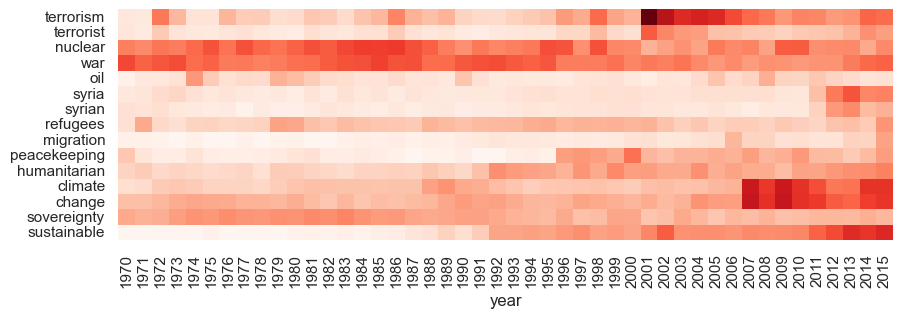

In [129]:
# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(10, 3)) ###
sns.set(font_scale=1) ###
sns.heatmap(data=freq_df.T, 
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1) ###

# this is not a distribution of topics